In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy.signal import butter, lfilter

# Load the audio file
sample_rate, audio_data = wavfile.read('mastermind.wav')

# Function to apply a lowpass filter
def butter_lowpass_filter(data, cutoff, fs, order=5):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = lfilter(b, a, data)
    return y

# Apply a lowpass filter
cutoff_frequency = 3000
filtered_audio_data = butter_lowpass_filter(audio_data, cutoff_frequency, sample_rate)

# Function to perform sliding window FFT
def sliding_window_fft(audio, window_size, step_size, sample_rate):
    fft_values = []
    times = []
    num_windows = (len(audio) - window_size) // step_size
    for i in range(num_windows):
        start = i * step_size
        end = start + window_size
        windowed_audio = audio[start:end] * np.hanning(window_size)
        fft_value = np.fft.fft(windowed_audio)
        fft_values.append(np.abs(fft_value[:window_size//2]))
        times.append((start + end) // 2 / sample_rate)
    return np.array(fft_values).T, np.array(times)

# Perform sliding window FFT
window_size = 1024
step_size = 256
fft_values, times = sliding_window_fft(filtered_audio_data, window_size, step_size, sample_rate)
frequencies = np.fft.fftfreq(window_size, 1/sample_rate)[:window_size//2]

# DTMF keypad frequencies mapping
low_frequencies = [697, 770, 852, 941]
high_frequencies = [1209, 1336, 1477, 1633]
dtmf_mapping = {
    (697, 1209): '1', (697, 1336): '2', (697, 1477): '3', (697, 1633): 'A',
    (770, 1209): '4', (770, 1336): '5', (770, 1477): '6', (770, 1633): 'B',
    (852, 1209): '7', (852, 1336): '8', (852, 1477): '9', (852, 1633): 'C',
    (941, 1209): '*', (941, 1336): '0', (941, 1477): '#', (941, 1633): 'D'
}

# Find the nearest frequency in the given list
def find_nearest_frequency(frequency, frequency_list):
    return min(frequency_list, key=lambda x: abs(x - frequency))

# Function to format timestamp
def format_timestamp(time_in_seconds):
    seconds = int(time_in_seconds)
    milliseconds = int((time_in_seconds % 1) * 1000)
    return f"{seconds}.{milliseconds:03d}"

In [2]:
import pandas as pd

# Function to detect DTMF tones with top-2 FFT frequencies and detected characters
def detect_dtmf_tones_with_characters(fft_values, frequencies, low_frequencies, high_frequencies, dtmf_mapping):
    detected_tones = []
    for i, time_slice in enumerate(fft_values.T):
        # Find the indices of the two most intensive frequencies
        top_two_indices = np.argsort(time_slice)[-2:][::-1]
        top_two_frequencies = frequencies[top_two_indices]
        top_two_intensities = time_slice[top_two_indices]
        
        fft_freq1 = min(top_two_frequencies)
        fft_freq2 = max(top_two_frequencies)
        # Identify low and high frequencies based on the top two frequencies
        low_freq = find_nearest_frequency(fft_freq1, low_frequencies)
        high_freq = find_nearest_frequency(fft_freq2, high_frequencies)
                
        # Map to DTMF character
        detected_character = dtmf_mapping.get((low_freq, high_freq), None)
        
        # Get the corresponding time in seconds
        time_in_seconds = times[i]
        
        # Append to detected tones
        detected_tones.append((time_in_seconds, low_freq, high_freq, [fft_freq1, fft_freq2], top_two_intensities, detected_character))

    return detected_tones

# Detect DTMF tones with top-2 FFT frequencies and detected characters
detected_tones_with_characters = detect_dtmf_tones_with_characters(fft_values, frequencies, low_frequencies, high_frequencies, dtmf_mapping)

# Creating a list of dictionaries for detected tones with characters
detected_tones_data_with_characters = []
for result in detected_tones_with_characters:
    timestamp, low_freq, high_freq, fft_freqs, intensities, character = result
    detected_tones_data_with_characters.append({
        'timestamp': timestamp,
        'low_freq': low_freq,
        'high_freq': high_freq,
        'fft_freq1': fft_freqs[0],
        'fft_freq2': fft_freqs[1],
        'intensity1': intensities[0],
        'intensity2': intensities[1],
        'character': character
    })

# Converting the list of dictionaries into a pandas DataFrame with characters
detected_tones_df_with_characters = pd.DataFrame(detected_tones_data_with_characters)

# Displaying the first 10 rows of the DataFrame with characters
detected_tones_df_with_characters.head(10)


,timestamp,low_freq,high_freq,fft_freq1,fft_freq2,intensity1,intensity2,character
0,0.021333,770,1209,773.4375,1218.75,3.511336e+06,3.470464e+06,4
1,0.032000,770,1209,773.4375,1218.75,3.392952e+06,3.376236e+06,4
2,0.042667,770,1209,773.4375,1218.75,3.434289e+06,3.114715e+06,4
3,0.053333,770,1209,773.4375,1218.75,3.443253e+06,3.040695e+06,4
4,0.064000,770,1209,773.4375,1218.75,3.591710e+06,3.234229e+06,4
5,0.074667,770,1209,773.4375,1218.75,3.722985e+06,3.459659e+06,4
6,0.085333,770,1209,773.4375,1218.75,3.734653e+06,3.553028e+06,4
7,0.096000,770,1209,773.4375,1218.75,3.758490e+06,3.554590e+06,4
8,0.106667,770,1209,773.4375,1218.75,3.834144e+06,3.555176e+06,4
9,0.117333,770,1209,773.4375,1218.75,3.906193e+06,3.554857e+06,4


In [3]:
tones = detected_tones_df_with_characters

In [4]:
tones = tones[(tones.intensity2 * tones.intensity1) > 1e12]

In [5]:
tones.sample(10)

,timestamp,low_freq,high_freq,fft_freq1,fft_freq2,intensity1,intensity2,character
154,1.664000,697,1477,703.1250,1476.5625,3.775509e+06,3.634372e+06,3
130,1.408000,697,1477,703.1250,1476.5625,2.869791e+06,2.811558e+06,3
1995,21.301333,941,1336,937.5000,1335.9375,3.781173e+06,3.731322e+06,0
1160,12.394667,697,1477,703.1250,1476.5625,3.783093e+06,3.619945e+06,3
9,0.117333,770,1209,773.4375,1218.7500,3.906193e+06,3.554857e+06,4
1148,12.266667,697,1477,703.1250,1476.5625,3.780746e+06,3.617920e+06,3
2160,23.061333,941,1336,937.5000,1335.9375,3.782510e+06,3.744816e+06,0
1592,17.002667,770,1336,773.4375,1335.9375,3.546846e+06,3.498236e+06,5
1770,18.901333,852,1209,843.7500,1218.7500,3.518481e+06,3.325828e+06,7
2031,21.685333,852,1477,843.7500,1476.5625,3.779516e+06,3.495370e+06,9


In [6]:
tones

,timestamp,low_freq,high_freq,fft_freq1,fft_freq2,intensity1,intensity2,character
0,0.021333,770,1209,773.4375,1218.7500,3.511336e+06,3.470464e+06,4
1,0.032000,770,1209,773.4375,1218.7500,3.392952e+06,3.376236e+06,4
2,0.042667,770,1209,773.4375,1218.7500,3.434289e+06,3.114715e+06,4
3,0.053333,770,1209,773.4375,1218.7500,3.443253e+06,3.040695e+06,4
4,0.064000,770,1209,773.4375,1218.7500,3.591710e+06,3.234229e+06,4
...,...,...,...,...,...,...,...,...
3339,35.637333,697,1209,187.5000,210.9375,1.718614e+06,1.440572e+06,1
3340,35.648000,697,1209,187.5000,210.9375,1.637748e+06,1.536522e+06,1
3341,35.658667,697,1209,187.5000,210.9375,1.674273e+06,1.452192e+06,1
3342,35.669333,697,1209,187.5000,210.9375,1.711857e+06,1.232765e+06,1


In [7]:
tones['delta'] = ((tones['fft_freq1'] - tones['low_freq']).abs() * (tones['fft_freq2'] - tones['high_freq']).abs())

/tmp/ipykernel_2009135/824670098.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tones['delta'] = ((tones['fft_freq1'] - tones['low_freq']).abs() * (tones['fft_freq2'] - tones['high_freq']).abs())


<Axes: >

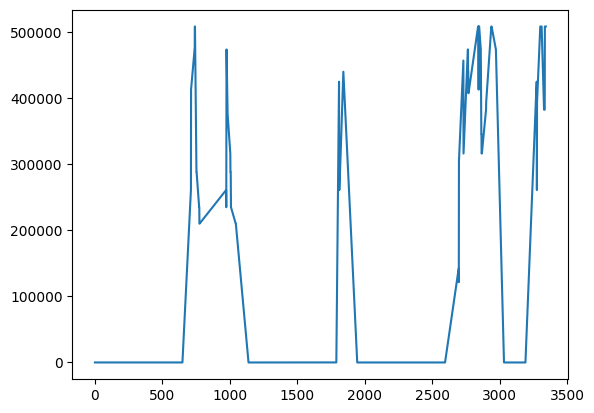

In [8]:
tones['delta'].plot()

In [9]:
tones = tones[tones['delta'] < 10 ** 4]

In [10]:
tones['character_prev'] = tones['character'].shift()

/tmp/ipykernel_2009135/3924296832.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tones['character_prev'] = tones['character'].shift()


In [11]:
tones_sequence = tones.copy()
tones_sequence['sequence_index'] = (~(tones['character'] == tones['character_prev'])).cumsum()
# [~(tones['character'] == tones['character_prev'])][['timestamp', 'character']]

In [12]:
tones_sequence['count'] = 1

In [13]:
tones_sequence = tones_sequence.groupby('sequence_index').agg({'count': 'sum', 'character': 'first', 'timestamp': 'first'})

In [14]:
tones_sequence['count'] = (tones_sequence['count'] / 28).round().astype(int)

In [15]:
tones_sequence['phrase_index'] = ((tones_sequence['timestamp'] - tones_sequence['timestamp'].shift()) / 0.35 > 3).cumsum()

In [16]:
tones_sequence = tones_sequence.groupby('phrase_index').agg({'character': list, 'count': list})

In [17]:
tones_sequence.apply(lambda x: ''.join([a * b for a, b in zip(*x)]), axis=1)

phrase_index
0    41323036267601217574
1    36710992825315281347
2    60924906937541136999
3                   02333
dtype: object

In [21]:
value = int(''.join(tones_sequence.apply(lambda x: ''.join([a * b for a, b in zip(*x)]), axis=1)))

In [24]:
# Converting to hexadecimal
hex_representation = hex(value)
hex_representation

hex_string = hex_representation[2:] # Removing the '0x' prefix
bytes_representation = bytes.fromhex(hex_string)
bytes_representation.decode()

'dsc{m0th3r_1s_m0th3r1ng_ts}'